In [ ]:
# Install required packages.
import torch
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric


In [1]:

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    #z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    z = TSNE(n_components=2).fit_transform(h)
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Node Classification with Graph Neural Networks

[Previous: Introduction: Hands-on Graph Neural Networks](https://colab.research.google.com/drive/1D5Yl32FP3PX3LWJPj6KNutrJHpVZVLMo#scrollTo=NgcpV4rjAWy-)

This tutorial will teach you how to apply **Graph Neural Networks (GNNs) to the task of node classification**.
Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).

To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# 1 - Get the first graph object.
data = dataset[0]
print()
print(data)
print('===========================================================================================================')

# 2 - Gather some statistics about the graph. (Add your code between the brackets)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Overall, this dataset is quite similar to the previously used [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) network.
We can see that the `Cora` network holds 2,708 nodes and 10,556 edges, resulting in an average node degree of 3.9.
For training this dataset, we are given the ground-truth categories of 140 nodes (20 for each class).
This results in a training node label rate of only 5%.

In contrast to `KarateClub`, this graph holds the additional attributes `val_mask` and `test_mask`, which denotes which nodes should be used for validation and testing.
Furthermore, we make use of **[data transformations](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms) via `transform=NormalizeFeatures()`**.
Transforms can be used to modify your input data before inputting them into a neural network, *e.g.*, for normalization or data augmentation.
Here, we [row-normalize](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeatures) the bag-of-words input feature vectors.

We can further see that this network is undirected, and that there exists no isolated nodes (each document has at least one citation).

## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [3]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)

        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        #x = torch.nn.Softmax(dim=-1)(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by following a similar procedure as described in [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8).
We again make use of the **cross entropy loss** and **Adam optimizer**.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [4]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion with crossEntropyLoss.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.
# Add your code where needed
def train(data):
      model.train()
      optimizer.zero_grad() # 1- Clear gradients.
      out = model(data.x) # 2- Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask]) # 3- Compute the loss solely based on the training nodes.
      loss.backward() # 4- Derive gradients.
      optimizer.step() # 5- Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      print(out)
      print(out.shape)
      pred = torch.argmax(out[data.test_mask],dim=1) # 6- Set the predicted value to the class with highest probability.
      test_acc = torch.sum(pred == data.y[data.test_mask])# 7- Check against ground-truth labels.
      test_acc = test_acc/len(data.y[data.test_mask]) # 8- Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train(data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

In [5]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

tensor([[-1.5070, -1.0389, -0.4587,  ..., -1.2218, -3.2381, -2.7267],
        [-0.6575, -0.4981, -1.0979,  ...,  2.6774, -1.9951, -1.3568],
        [-0.4404, -1.1500, -0.6713,  ...,  2.6507, -2.1048, -1.4845],
        ...,
        [-0.5195,  0.7947, -1.7014,  ..., -0.9291,  0.3580, -1.2500],
        [-1.8679, -1.5536,  0.2021,  ...,  0.5849, -1.9512, -1.7330],
        [-0.1774, -0.3289, -0.9715,  ..., -0.1010, -2.1859, -1.8909]],
       grad_fn=<AddmmBackward0>)
torch.Size([2708, 7])
Test Accuracy: 0.5900


**Question**: Comment the results, why do you think the model behaves poorly? 

**Answer**: We had an accuracy measure of 59%. The model problably behaves like that, because it didn't take into account the existant relation between the documents caused by the "cited papers" feature in the edges of the graph. This must be an important indicator of the document's category.

**Remark:** The model fails to incorporate an important bias into the model: **Cited papers are very likely related to the category of a document**.
That is exactly where Graph Neural Networks come into play and can help to boost the performance of our model.



## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single linear layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [6]:
from torch_geometric.nn import GCNConv
# Create a GCN with the number of hidden channels = 16 
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(1234567)
        # 9 - define Two Graph Convolutional layers self.conv1 and self.conv2, carfully define input and output size
        self.conv1 = GCNConv(dataset.num_features,hidden_channels)
        self.conv2 = GCNConv(hidden_channels,dataset.num_classes)
        

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index) # 10 - compute x <- Output of the first convolutional layer .
        h = h.relu()# 11 - compute x <- ReLU (x)
        h = F.dropout(h, p=0.5, training=self.training) # 12 - compute x <- Dropout with p=0.5 
        h = self.conv2(h, edge_index) # 13 - compute x <- Output of the second convolutional layer
        return h

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

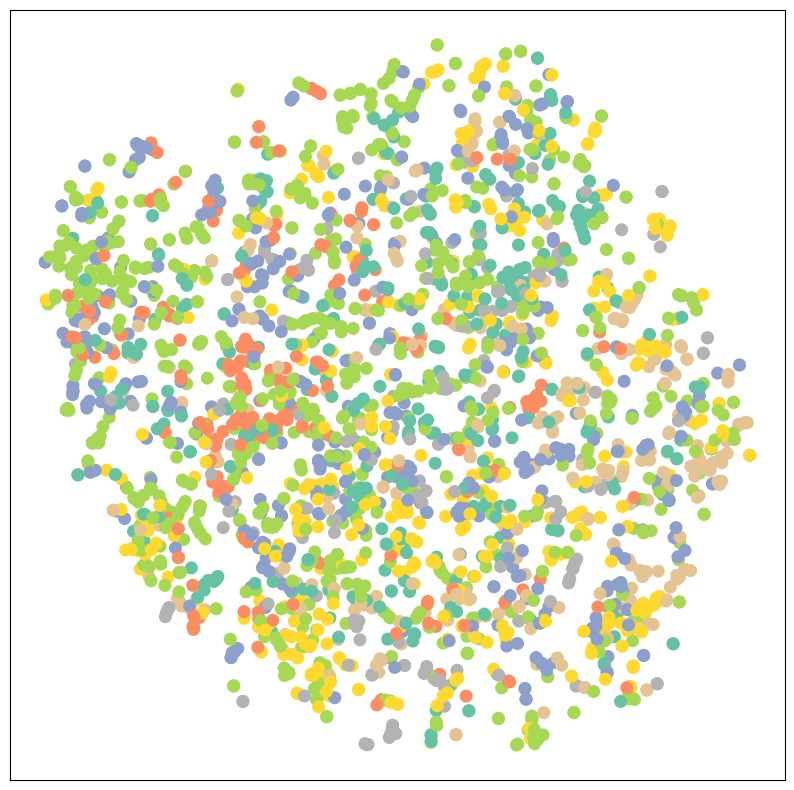

In [8]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out.detach().numpy(), color=data.y)


**Question**: What do you observe ? Comment the results of T-SNE. 

**Answer**: We observe a huge cloud of colored points (7 colors). The points are the documents and the colors are related to its category. The TSNE embedding seems to spatially aggregate the points according to the similarity rate among them. This similarity is based on the weight given to the edges. Since we didn't train our model yet, the model doesn't have a clear separation between the categories yet.

The training and testing procedure is once again the same, but this time we make use of the node features `x` **and** the graph connectivity `edge_index` as input to our GCN model.

In [9]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train(data):
      model.train()
      optimizer.zero_grad() # Clear gradients.
      out = model(data.x, data.edge_index)# Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask]) # Compute the loss solely based on the training nodes.
      loss.backward() # Derive gradients.
      optimizer.step() # Update parameters based on gradients.
      return loss

def test(data):
      model.eval()
      out = model(data.x, data.edge_index)
      print(out)
      print(out.shape)
      pred = torch.argmax(out[data.test_mask],dim=1) # Use the class with highest probability.
      test_acc = torch.sum(pred == data.y[data.test_mask])# 7- Check against ground-truth labels.
      test_acc = test_acc/len(data.y[data.test_mask]) # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train(data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


After training the model, we can check its test accuracy:

In [10]:
test_acc = test(data)
print(f'Test Accuracy: {test_acc:.4f}')
# .4f : is to restrict the numbers after the comma (float number with 4 values after the comma)

tensor([[ 0.2403,  0.0196, -0.3496,  ...,  0.5438, -0.3199, -0.7708],
        [ 0.4004,  0.0821, -0.5381,  ...,  3.1453, -1.0978, -0.1976],
        [ 0.4525,  0.0232, -0.4915,  ...,  2.4685, -1.0065, -0.4806],
        ...,
        [ 1.3991,  1.0721, -1.9290,  ..., -0.9146,  0.8002, -0.2734],
        [ 0.4402,  0.1981, -0.3511,  ...,  0.8219, -0.3904, -0.9392],
        [ 0.2887,  0.2146, -0.1874,  ...,  0.5880, -0.3354, -0.8654]],
       grad_fn=<AddBackward0>)
torch.Size([2708, 7])
Test Accuracy: 0.8150


**There it is!**
By simply swapping the linear layers with GCN layers, we can reach **81.5% of test accuracy**!

**Question**: How do you explain this result ? Why does a GCN do better than a linear layer ? 

**Answer**: Based on what we said in the previous answers, a GCN is able to create a model that takes into consideration the edges information, that means, the "cited papers" information. Thus, we have a better result  than using a linear layer.

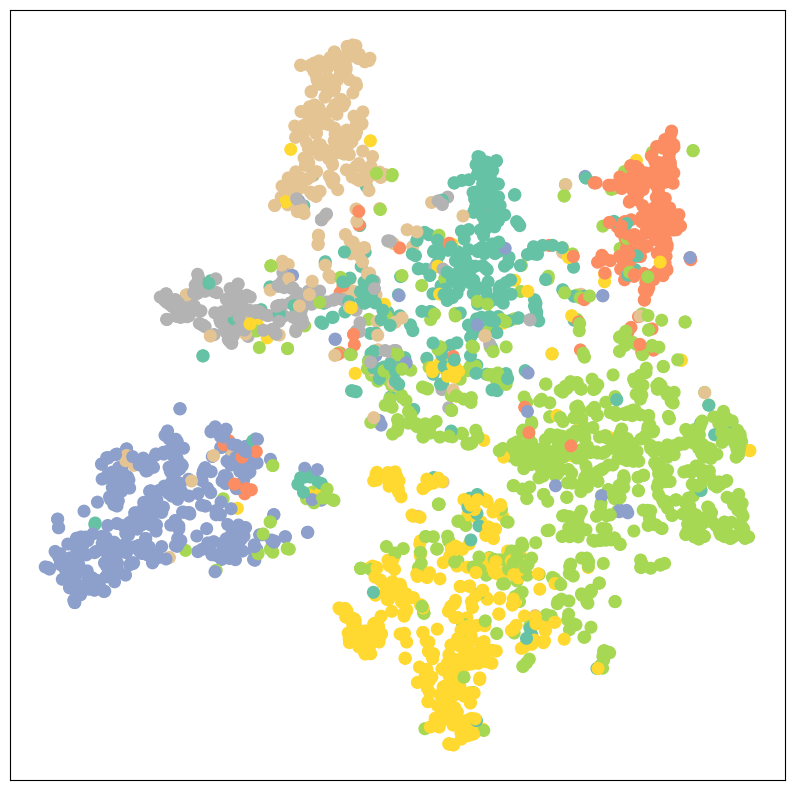

In [11]:
# Evaluate the model on the original graph (containing all nodes/edges) and show its embedding using t-SNE.
# Verify by looking at the output embeddings of the trained model. It should produce a far better clustering of nodes of the same category.

model.eval()

out = model(data.x, data.edge_index)
visualize(out.detach().numpy(), color=data.y)

**Question** Comment the results. 

**Answer** Analyzing the figure, we can clearly see that the model better separates the 7 categories.

## Conclusion

In this notebook, you have seen how to apply GNNs to real-world problems, and, in particular, how they can effectively be used for boosting a model's performance.
In the next section, we will look into how GNNs can be used for the task of graph classification.

[Next: Graph Classification with Graph Neural Networks](https://colab.research.google.com/drive/1WZnUL_tzGk6VKCYLuOSzNddXZCvYPj6Z#scrollTo=zn5U4EE6K86v)

## (Optional) Exercises

1. To achieve better model performance and to avoid overfitting, it is usually a good idea to select the best model based on an additional validation set.
The `Cora` dataset provides a validation node set as `data.val_mask`, but we haven't used it yet.
Can you modify the code to select and test the model with the highest validation performance?
This should bring test performance to **82% accuracy**.


In [15]:
import copy

def validation_test(data):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = torch.argmax(out[data.val_mask],dim=1) # Use the class with highest probability.
      test_acc = torch.sum(pred == data.y[data.val_mask])# 7- Check against ground-truth labels.
      test_acc = test_acc/len(data.y[data.val_mask]) # Derive ratio of correct predictions.
      return test_acc

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

best_val = 0
for epoch in range(1, 101):
      loss = train(data)
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

      val_acc = validation_test(data)
      if (val_acc > best_val):
            best_model = copy.deepcopy(model)
            best_val = val_acc

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9397
Epoch: 003, Loss: 1.9340
Epoch: 004, Loss: 1.9286
Epoch: 005, Loss: 1.9215
Epoch: 006, Loss: 1.9088
Epoch: 007, Loss: 1.9011
Epoch: 008, Loss: 1.8960
Epoch: 009, Loss: 1.8860
Epoch: 010, Loss: 1.8768
Epoch: 011, Loss: 1.8651
Epoch: 012, Loss: 1.8544
Epoch: 013, Loss: 1.8479
Epoch: 014, Loss: 1.8296
Epoch: 015, Loss: 1.8224
Epoch: 016, Loss: 1.8196
Epoch: 017, Loss: 1.7947
Epoch: 018, Loss: 1.7765
Epoch: 019, Loss: 1.7615
Epoch: 020, Loss: 1.7482
Epoch: 021, Loss: 1.7376
Epoch: 022, Loss: 1.7049
Epoch: 023, Loss: 1.7020
Epoch: 024, Loss: 1.6950
Epoch: 025, Loss: 1.6607
Epoch: 026, Loss: 1.6679
Epoch: 027, Loss: 1.6361
Epoch: 028, Loss: 1.6322
Epoch: 029, Loss: 1.6125
Epoch: 030, Loss: 1.5879
Epoch: 031, Loss: 1.5646
Epoch: 032, Loss: 1.5584
Epoch: 033, Loss: 1.5460
Epoch: 034, Loss: 1.4765
Epoch: 035, Loss: 1.4930
Epoch: 036, Loss: 1.4541
Epoch: 037, Loss: 1.4375
Epoch: 038, Loss: 1.4153
Epoch: 039, Loss: 1.4374
Epoch: 040, Loss: 1.4018


In [16]:
def test_bestmodel(data):
      best_model.eval()
      out = best_model(data.x, data.edge_index)
      pred = torch.argmax(out[data.test_mask],dim=1) # Use the class with highest probability.
      test_acc = torch.sum(pred == data.y[data.test_mask])# 7- Check against ground-truth labels.
      test_acc = test_acc/len(data.y[data.test_mask]) # Derive ratio of correct predictions.
      return test_acc

test_acc = test_bestmodel(data)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8160



2. How does `GCN` behave when increasing the hidden feature dimensionality or the number of layers?
Does increasing the number of layers help at all?

**Answer**: This might depend on the task, dataset and the complexity of the graph structure, but we can make some few considerations. **Increasing the hidden feature dimensionality** can potentially capture more complex patterns in the data, so this can lead to a more powerful representation of nodes in the graph. However, it increases the risk of overfitting, especially for small datasets. **Adding more layers** allows the model to capture hierarchical features and more complex relationships within the graph, but also demands a bigger computational cost. In some cases, a single-layer GCN might be sufficient for simpler tasks or datasets with less complex graph structures.